# 0-Introduction

This notebook details Group 1’s comprehensive approach to developing a robust sign language recognition system(SLR) using deep learning techniques. Sign language is a crucial form of communication for the hearing-impaired communities, enabling expressive interaction through hand gestures, facial expressions, and body movements. However, the lack of widespread sign language proficiency among the general population creates significant communication barriers. With advancements in computer vision and deep learning, there is growing potential to bridge this gap through automatic sign language recognition (SLR) systems.

This project aims to build a robust, real-time SLR system that can recognize American Sign Language (ASL) gestures from video data. Our focus is on leveraging a Transformer-based model, a modern deep learning architecture that has shown superior performance in sequence modeling tasks due to its ability to capture long-range dependencies using self-attention. To benchmark performance, we also develop two baseline models: a traditional LSTM model and a Multilayer Perceptron (MLP). These models serve as points of comparison to validate the effectiveness of the Transformer approach in sign language classification.


# 1-Preparation and Data Preprocessing

### 1.1-Import and Install Dependencies

The foundation of our system is the World Level American Sign Language (WLASL) dataset from Kaggle, which is a large-scale ASL video corpus containing a diverse range of signers and gesture variations. The dataset presents challenges typical of unconstrained environments, including variations in lighting, background, and signer appearance. To prepare the data, we extract landmarks from each video using MediaPipe, capturing important landmarks through 3D coordinates of keypoints on the face, hands, and body. These per-frame keypoints are then transformed into fixed-length sequences of 225-dimensional vectors, normalized, and padded to ensure consistency across all samples.

The core model of this project is a Transformer encoder network. Its self-attention mechanism enables it to analyze spatial and temporal dependencies across the entire sequence simultaneously, making it highly suitable for recognizing subtle variations in gesture execution. The Transformer is trained and fine-tuned using KerasTuner to explore hyperparameters such as embedding size, number of heads, feedforward dimensions, and dropout rates. To evaluate performance, we also train LSTM and MLP models as baselines. The LSTM captures temporal patterns sequentially, while the MLP treats each sample as a static feature vector. During testing, we evaluate the models on both a dedicated test dataset, which provides a controlled environment for measuring accuracy and consistency, and real-time camera feeds that simulate practical scenarios with dynamic variations in hand positioning, lighting, and background. Through quantitative metrics and qualitative visualizations, we analyze the performance of the Transformer model compared with the baseline models.


In [ ]:
!pip install kagglehub
#!pip install mediapipe
!pip install tensorflow
!pip install numpy
!pip install opencv-python
!pip install matplotlib
!pip install sklearn
!pip install pandas
# If you encounter: "name 'audio_classifier' is not defined, try this:pip install mediapipe-model-maker, and restart the kernel
# !pip install mediapipe==0.10.20
# !pip install mediapipe-model-maker

from google.colab import drive
import os
import zipfile
import kagglehub
import json
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.utils import to_categorical
from google.colab.patches import cv2_imshow
from google.colab import files
import time
from IPython.display import clear_output
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
import seaborn as sns
import pandas as pd

In [ ]:
!pip install mediapipe-model-maker

### 1.2-Locate the Video Path for each Label

We are using the dataset from Word Level American Sign Language from Kaggle: https://www.kaggle.com/datasets/risangbaskoro/wlasl-processed

It could also be downloaded through Kaggle API with :

    import kagglehub
    from kagglehub import KaggleDatasetAdapter

    file_path = ""

    df = kagglehub.load_dataset(
      KaggleDatasetAdapter.PANDAS,
      "risangbaskoro/wlasl-processed",
      file_path,
    )

However, for convenience, the team has already downloaded the data and will load the video to facilitate easier use.

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define paths
drive_path = "/content/drive/My Drive/MIE1517_Project"
zip_file = os.path.join(drive_path, "videos.zip")
unzip_path = "/content/WLASL_videos"  # Unzipped directory

In [ ]:
# Unzip the dataset
if not os.path.exists(unzip_path):
    os.makedirs(unzip_path, exist_ok=True)

    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(unzip_path)

print(f"Videos extracted to: {unzip_path}")

In [ ]:
json_file = "WLASL_v0.3.json"

# Load JSON
with open(json_file, "r") as f:
    data = json.load(f)

# Extract the labels and their video filenames
labels = []
label_to_video_filenames = {}

for entry in data[0:300]:
    gloss = entry["gloss"]  # ASL word/ label
    labels.append(gloss)  # Store label

    # Extract video filenames for this word
    video_filenames = [f"{instance['video_id']}.mp4" for instance in entry["instances"] if "video_id" in instance]

    label_to_video_filenames[gloss] = video_filenames

# Print results
print("Labels:", labels)
print("Label to Video Mapping (First 300 Labels):")
for label, filenames in label_to_video_filenames.items():
    print(f"{label}: {len(filenames)}...")

### 1.3-Landmark/Feature Extraction

The WLASL dataset contains about 12k ASL sign videos performed by different individuals in varied environments. To prepare the dataset for model training, we apply a consistent pipeline that transforms each video into a structured numerical representation. Using the MediaPipe Holistic model, we extract spatial landmarks corresponding to the human body, hands, and facial features for each frame. For this work, we focus on three key landmark regions: 33 pose landmarks, 21 left-hand landmarks, and 21 right-hand landmarks. Each landmark includes three coordinates (x, y, z), resulting in a total of 225 numerical features per frame.
All video sequences are standardized to 60 frames in length. If a video contains fewer than 60 frames, we pad the sequence with zero vectors to preserve temporal consistency across samples. Videos exceeding the frame limit are truncated. This ensures that each input has a fixed shape of (60, 225), facilitating efficient batch training and compatibility with sequence models.
To promote class balance and avoid overfitting, we limit the number of usable samples per label to a maximum of 13 and discard any labels with fewer than 13 qualifying videos. The resulting label set is encoded using one-hot vectors to support categorical classification tasks. Finally, the complete dataset is partitioned into training (70%), validation (20%), and test (10%) subsets using stratified sampling. This ensures each subset maintains a consistent distribution of gesture classes, thereby providing robust evaluation conditions for model selection and performance assessment.


In [ ]:
# Initialize Mediapipe holistic model
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def extract_video_features(video_path, frame_sequence_length= 60):
    cap = cv2.VideoCapture(video_path)
    frames = []

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while len(frames) < frame_sequence_length:
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Process frame with Mediapipe
            results = holistic.process(frame_rgb)

            frame_features = []

            # Draw landmarks and connections
            annotated_frame = frame.copy()

            # Draw Pose landmarks
            if results.pose_landmarks:
                mp_drawing.draw_landmarks(annotated_frame, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
                for landmark in results.pose_landmarks.landmark:
                    frame_features.extend([landmark.x, landmark.y, landmark.z])
            else:
                frame_features.extend([0] * 99)  # Pad with zeros if missing landmarks

            # Draw Left Hand landmarks
            if results.left_hand_landmarks:
                mp_drawing.draw_landmarks(annotated_frame, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
                for landmark in results.left_hand_landmarks.landmark:
                    frame_features.extend([landmark.x, landmark.y, landmark.z])
            else:
                frame_features.extend([0] * 63)

            # Draw Right Hand landmarks
            if results.right_hand_landmarks:
                mp_drawing.draw_landmarks(annotated_frame, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
                for landmark in results.right_hand_landmarks.landmark:
                    frame_features.extend([landmark.x, landmark.y, landmark.z])
            else:
                frame_features.extend([0] * 63)

            # Draw Face landmarks
            if results.face_landmarks:
                mp_drawing.draw_landmarks(annotated_frame, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)

            frames.append(frame_features)

    cap.release()
    cv2.destroyAllWindows()

    # Ensure sequence has exactly `frame_sequence_length` frames
    while len(frames) < frame_sequence_length:
        frames.append([0] * (99 + 63 + 63))  # Pad with zeros for missing frames

    return np.array(frames)

### 1.4-Data Preprocessing (Ensure Balance)

To ensure the dataset is both clean and representative, the team decides to discard labels that have very few videos and retain only those with an adequate number of video samples.

These functions are designed to load and preprocess video data for model training. Both functions extract features from the videos and generate corresponding one-hot encoded labels for use in training a classification model.

In [ ]:
def process_dataset_balanced(dataset_dir, labels, label_to_video_filenames):
    """
    Loads video data for the specified labels from the dataset directory.

    - Filters out labels that have fewer than 13 videos.
    - Ensures each label has exactly 13 successfully processed videos before including it.
    """
    X = []
    y = []
    final_labels = []

    # Filter out labels with fewer than 13 videos
    filtered_labels = [
        label for label in labels
        if label in label_to_video_filenames and len(label_to_video_filenames[label]) >= 13
    ]

    # Notify about skipped labels
    removed_labels = set(labels) - set(filtered_labels)
    if removed_labels:
        print(f"Skipping labels due to insufficient videos (<13): {', '.join(removed_labels)}")

    # Temporary storage
    temp_X = {}
    temp_y = {}

    # Process videos for each valid label
    for label in filtered_labels:
        print(f"Processing label: {label}")
        processed_videos = 0
        temp_X[label] = []
        temp_y[label] = []

        # Select up to 13 videos per label (to ensure balance)
        selected_videos = label_to_video_filenames[label][:]

        for video_file in selected_videos:
            video_path = os.path.join(dataset_dir, video_file)

            if os.path.exists(video_path):
                print(f"Processing video: {video_path}")
                features = extract_video_features(video_path)

                if features is not None and len(features) > 0:
                    temp_X[label].append(features)
                    temp_y[label].append(label)
                    processed_videos += 1

                if processed_videos == 13:
                    break

        # Only include this label if at least 13 videos were successfully processed
        if processed_videos == 13:
            final_labels.append(label)
            X.extend(temp_X[label])
            y.extend(temp_y[label])
        else:
            print(f"Skipping label {label} due to insufficient processed videos ({processed_videos}/13).")

    # Convert to NumPy arrays
    X = np.array(X)
    y = np.array(y)

    if len(X) == 0:
        print("Error: No video features extracted. Check extract_video_features() function.")

    # One-hot encode the labels based on the number of final valid labels
    label_map = {label: i for i, label in enumerate(final_labels)}
    y = np.array([label_map[label] for label in y])  # Convert label names to index values
    y = to_categorical(y, num_classes=len(final_labels))

    print(f"Final labels used for training: {final_labels}")

    return X, y, final_labels

def process_dataset_no_filter(dataset_dir, labels, label_to_video_filenames):
    """
    Loads video data for the specified labels from the dataset directory.
    Processes all labels provided in the `labels` list, regardless of the number of videos.
    """
    X = []
    y = []

    # Create a label-to-index mapping using all labels
    label_map = {label: i for i, label in enumerate(labels)}

    # Process videos for each label
    for label in labels:
        if label in label_to_video_filenames:
            print(f"Processing label: {label}")

            for video_file in label_to_video_filenames[label]:
                video_path = os.path.join(dataset_dir, video_file)

                if os.path.exists(video_path):
                    print(f"Processing video: {video_path}")
                    features = extract_video_features(video_path)

                    if features is not None and len(features) > 0:
                        X.append(features)
                        y.append(label_map[label])
                    else:
                        print(f"Feature extraction failed for: {video_path}")
                else:
                    continue

    X = np.array(X)
    y = np.array(y)

    if len(X) == 0:
        print("Error: No video features extracted. Check extract_video_features() function.")

    # One-hot encode
    y = to_categorical(y, num_classes=len(labels))

    print(f"Final processed labels: {list(label_map.keys())}")

    return X, y, list(label_map.keys())  # Return final labels used


In [ ]:
dataset_dir = "/content/WLASL_videos"

#Process dataset
X, y, y_labels = process_dataset_balanced(dataset_dir, labels, label_to_video_filenames)

In [ ]:
# Save the feature
np.savez('train_wlasl_limit_13.npz', X = X, y = y)
print("X and y saved in a single file.")

# Download the file to your local machine
files.download('train_wlasl_limit_13.npz')

In [ ]:
# Load existing data
data = np.load('train_wlasl_limit_13.npz')
X_train_loaded = data['X']
y_train_loaded = data['y']

print("X_train and y_train loaded from .npz file.")

### 1.5-Visualize the Extracted Features

This section visualizes our extracted data. We display the extracted features (stored as a numpy array) along with the original video, demonstrating that these features closely correspond to the video's content. Although this step is not necessary for data preprocessing, this alignment confirms that MediaPipe provides high-quality inputs for our model.

In [ ]:
import matplotlib.pyplot as plt
def display_video_with_keypoints(video_path, X_train, start_frame=0):
    cap = cv2.VideoCapture(video_path)

    fig, ax = plt.subplots(1, 1)
    plt.ion()
    fig.show()
    fig.canvas.draw()

    # Read frames up to the starting frame
    for _ in range(start_frame):
        ret, _ = cap.read()
        if not ret:
            print("Error: Unable to read frames to reach starting frame.")
            return

    frame_idx = start_frame
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx >= len(X_train[0]):
            break

        key_points = X_train[0][frame_idx]
        x_coords = key_points[0::3]
        y_coords = key_points[1::3]

        if frame is None:
            print("Error: Unable to read frame.")
            break

        for x, y in zip(x_coords, y_coords):
            # Check if x and y are within the valid range before scaling
            if 0 <= x <= 1 and 0 <= y <= 1:
                x_scaled = int(x * frame.shape[1])
                y_scaled = int(y * frame.shape[0])
                cv2.circle(frame, (x_scaled, y_scaled), 2, (0, 255, 0), -1)

        # Convert BGR to RGB for Matplotlib display
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Update
        ax.clear()
        ax.imshow(frame_rgb)

        # Clear previous output and display current frame
        clear_output(wait=True)
        display(fig)
        time.sleep(0.1)

        frame_idx += 1

    cap.release()
    plt.ioff()

In [ ]:
path_test = '/content/00335.mp4'
test_array = extract_video_features(path_test)
print(test_array)

In [ ]:
display_video_with_keypoints(path_test, test_array)

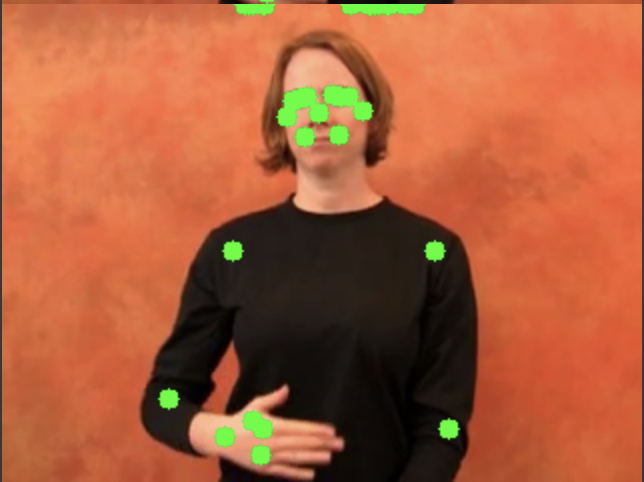

### 1.6-Data Split

After preprocessing the data, we filter the labels to retain only those with at least 13 videos. The dataset comprises videos and a JSON file, with most videos provided as URL links. However, many links are either missing or fail to download, and some videos show different versions of hand gestures for the same label. As a result, the number of usable labels was reduced to five to ensure a more precise and smooth training process.

In [ ]:
actions = np.array(['drink', 'before', 'go', 'thin', 'cool'])

In [ ]:
label_map = {label:num for num, label in enumerate(actions)}

In [ ]:
# First, split into training (70%) and temp (30% for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Now, split the remaining temp set into validation (20%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

# Print dataset sizes
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 52 samples
Validation set: 15 samples
Test set: 8 samples


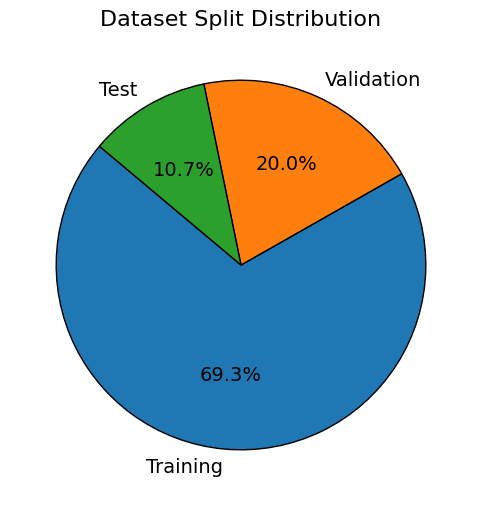

In [ ]:
# Dataset sizes
train_size = len(X_train)
val_size = len(X_val)
test_size = len(X_test)

# Label names and sizes
labels = ['Training', 'Validation', 'Test']
sizes = [train_size, val_size, test_size]

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140,
        wedgeprops={'edgecolor': 'black'}, textprops={'fontsize': 14})
plt.title("Dataset Split Distribution", fontsize=16)
plt.show()


# 2-Model Implementations & Training

### 2.1-LSTM Neural Network

For the LSTM model, the architecture is built using a hyperparameter tuner to determine both the number of layers and the units in each layer. The network begins with 2 to 4 LSTM layers, where each layer’s number of units is selected from choices such as 64, 128, or 256. The first LSTM layer accepts input with a shape of (30, 225) – representing a sequence (for example, 30 time steps) of feature vectors (with 225 features each). All LSTM layers return sequences except for the last one. This is followed by fully connected layers: a Dense layer with tunable units (dense_1_units), then Dropout for regularization, and another Dense layer (dense_2_units), before finally passing through an output layer with softmax activation to produce class probabilities.

In [ ]:
!pip install keras-tuner

import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

##### 2.1.1-Build LSTM Model

In [ ]:
def build_lstm_model(hp):
    model = Sequential()

    # Define number of LSTM layers (2 to 4)
    num_lstm_layers = hp.Int("num_lstm_layers", min_value=2, max_value=4, step=1)

    for i in range(num_lstm_layers):
        units = hp.Choice(f"lstm_units_{i}", values=[64, 128, 256])
        return_sequences = i < (num_lstm_layers - 1)  # Ensure only last layer does not return sequences
        model.add(LSTM(units, return_sequences=return_sequences, activation='relu',
                       input_shape=(30, 225) if i == 0 else None))

    # Fully connected layers
    model.add(Dense(hp.Choice("dense_1_units", values=[32, 64, 128]), activation='relu'))
    model.add(Dropout(hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Choice("dense_2_units", values=[16, 32, 64]), activation='relu'))

    # Output layer
    model.add(Dense(len(actions), activation='softmax'))

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float("learning_rate", min_value=0.0001, max_value=0.001, step=0.0002),
                       clipnorm=1.0),
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"]
    )

    return model


##### 2.1.2 LSTM Hyperparameter Tunning

In [ ]:
import shutil

# delete old tuning directory
shutil.rmtree('lstm_tuning', ignore_errors=True)

tuner = kt.Hyperband(
    build_lstm_model,
    objective='val_categorical_accuracy',
    max_epochs=50,
    factor=3,
    directory='lstm_tuning',
    project_name='lstm_hyperparameter_tuning'
)

# Display search space summary
tuner.search_space_summary()

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,  # Set manually (or change as needed)
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best LSTM Units: {best_hps.get('lstm_units_0')}")
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")
print(f"Best Dense Layer Size: {best_hps.get('dense_1_units')}")

Trial 90 Complete [00h 00m 27s]
val_categorical_accuracy: 0.06666667014360428

Best val_categorical_accuracy So Far: 0.6666666865348816
Total elapsed time: 00h 32m 35s
Best LSTM Units: 256
Best Learning Rate: 0.0001
Best Dense Layer Size: 64


In [ ]:
# Save best hyperparameters
with open('best_hyperparameters_lstm.pkl', 'wb') as f:
    pickle.dump(best_hps, f)

print("Best hyperparameters saved successfully!")

Best hyperparameters saved successfully!


In [ ]:
# Load best hyperparameters
with open('best_hyperparameters_lstm.pkl', 'rb') as f:
    best_hps = pickle.load(f)

##### 2.1.3-Best Model for LSTM


In [ ]:
class CustomEarlyStopping(Callback):
    def __init__(self, loss_increase_threshold=3.0):
        super(CustomEarlyStopping, self).__init__()
        self.loss_increase_threshold = loss_increase_threshold  # Set loss tolerance
        self.best_loss = float("inf")  # Initialize best loss to a high value

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get("val_loss")  # Use validation loss

        # If it's the first epoch, set the best loss
        if self.best_loss == float("inf"):
            self.best_loss = current_loss
            return

        # Check if the increase in loss exceeds the threshold
        if (current_loss - self.best_loss) > self.loss_increase_threshold:
            print(f"\nStopping training: Loss increased from {self.best_loss:.4f} to {current_loss:.4f} (> {self.loss_increase_threshold})")
            self.model.stop_training = True

        # Update best loss if the current loss is lower
        if current_loss < self.best_loss:
            self.best_loss = current_loss

# Initialize the modified custom early stopping
custom_early_stopping = CustomEarlyStopping(loss_increase_threshold=2.0)

In [ ]:
# Extract best hyperparameters
num_lstm_layers = best_hps.get("num_lstm_layers")
lstm_units = [best_hps.get(f"lstm_units_{i}") for i in range(num_lstm_layers)]
dense_1_units = best_hps.get("dense_1_units")
dense_2_units = best_hps.get("dense_2_units")
dropout_rate = best_hps.get("dropout_rate")
learning_rate = best_hps.get("learning_rate")

# Define model
best_model_lstm = Sequential()

# Add LSTM layers based on best hyperparameters
for i in range(num_lstm_layers):
    return_sequences = i < (num_lstm_layers - 1)  # Ensure only last layer does not return sequences
    if i == 0:
        best_model_lstm.add(LSTM(lstm_units[i], return_sequences=return_sequences, activation='relu',
                                 input_shape=(30, 225)))
    else:
        best_model_lstm.add(LSTM(lstm_units[i], return_sequences=return_sequences, activation='relu'))

# Fully connected layers
best_model_lstm.add(Dense(dense_1_units, activation='relu'))
best_model_lstm.add(Dropout(dropout_rate))
best_model_lstm.add(Dense(dense_2_units, activation='relu'))

# Output layer
num_classes = len(actions)
best_model_lstm.add(Dense(num_classes, activation='softmax'))

# Compile model
optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)
best_model_lstm.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["categorical_accuracy"])

# Model Summary
best_model_lstm.summary()

history = best_model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[tb_callback, custom_early_stopping]
)

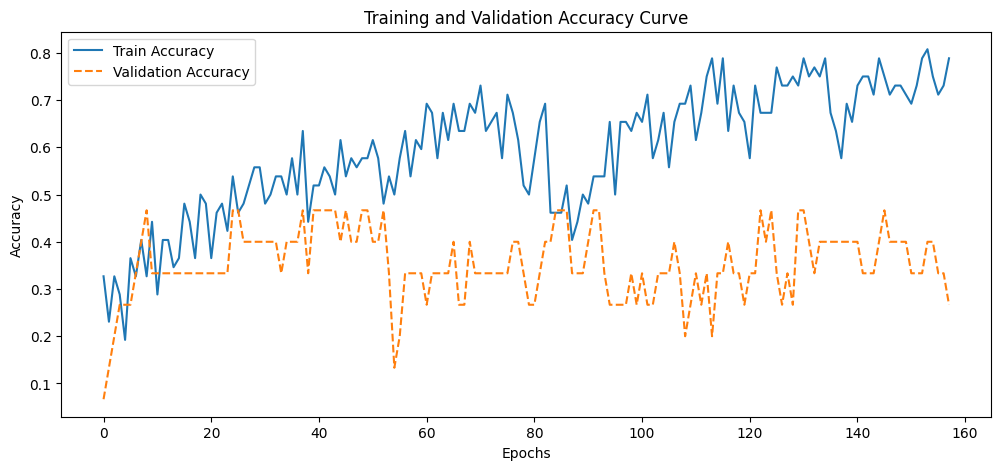

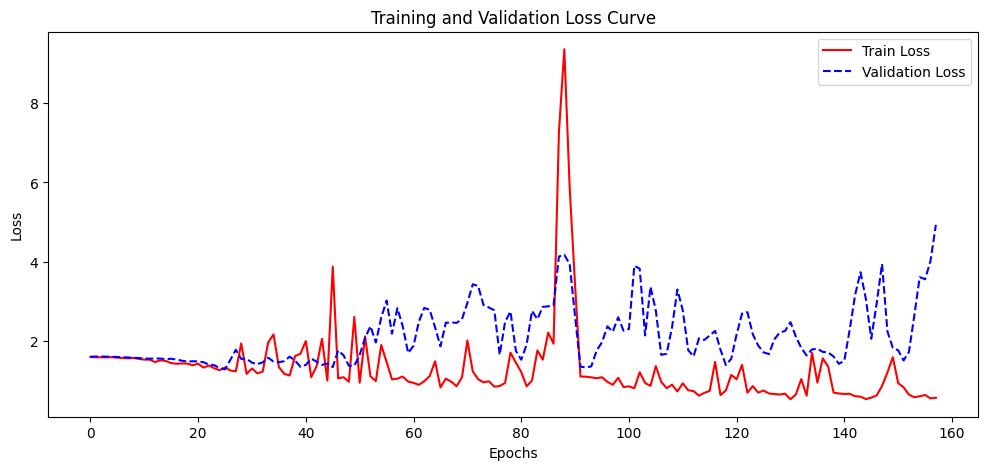

In [ ]:
# Plot Accuracy Curve
plt.figure(figsize=(12, 5))
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curve')
plt.legend()
plt.show()

# Plot Loss Curve
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

In [ ]:
best_model_lstm.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                       │ (None, 30, 256)             │         493,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 30, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,498,321 (9.53 MB)

 Trainable params: 832,773 (3.18 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,665,548 (6.35 MB)

In [ ]:
# save the model
best_model_lstm.save('lstm_model_wlasl.h5')

### 2.2-Transformer Model

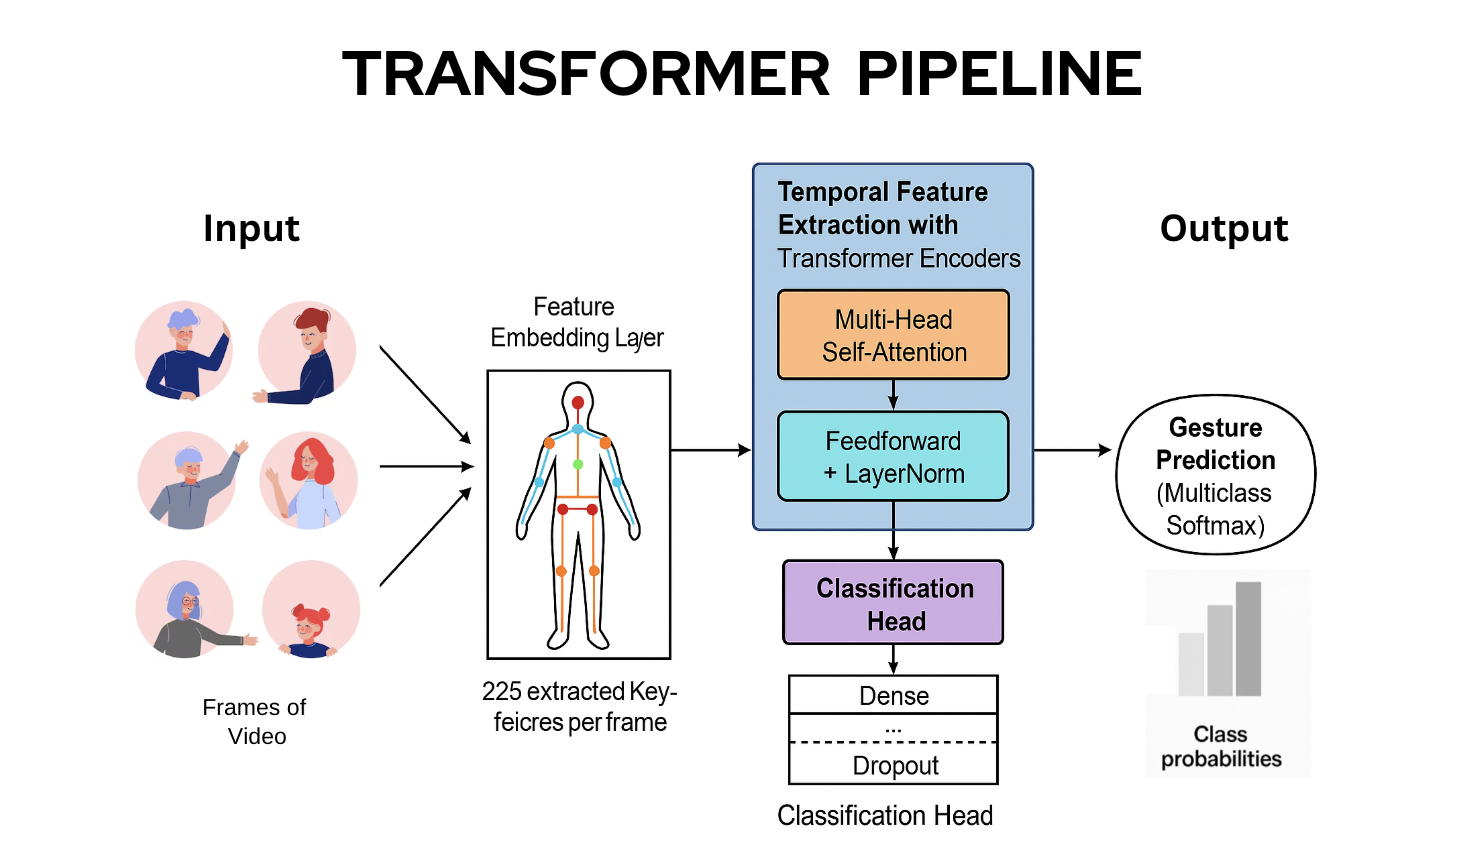

For the Transformer model, the network is designed to process sequential data with a fixed sequence length of 60 and an input feature size of 225. The model starts with an input projection layer that maps the original features into an embedding space of dimension “embed_dim” (tunable between 64 and 256). Next, it stacks a number of Transformer Encoder layers (from 1 to 3 layers, as determined by the tuner). Each encoder consists of a multi-head attention block – with the number of heads chosen from values between 2 and 8 – and a feed-forward network (with a tunable dimension between 128 and 512). Layer normalization and dropout are applied both after the attention and the feed-forward sub-layers to stabilize training. After these encoders, Global Average Pooling reduces the sequence dimension, and then one or two Dense layers (with tunable sizes) further process the information before an output layer with softmax activation provides the final classification.


In [ ]:
!pip install keras-tuner

import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Layer

##### 2.2.1-Build Transformer Model

In [ ]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)  # Ensure output matches embedding size
        ])

    def call(self, inputs, training=False):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.norm2(out1 + ffn_output)

def build_transformer_model(hp):
    sequence_length = 60  # Keep sequence length fixed
    feature_dim = 225  # Number of input features
    num_classes = len(actions)  # Number of action classes

    embed_dim = hp.Int('embed_dim', min_value=64, max_value=256, step=64)  # Tunable embedding size
    num_heads = hp.Int('num_heads', min_value=2, max_value=8, step=2)  # Number of attention heads
    ff_dim = hp.Int('ff_dim', min_value=128, max_value=512, step=128)  # Feed-forward layer size
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)  # Dropout rate
    num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)  # Number of Transformer layers

    # Input layer
    inputs = Input(shape=(sequence_length, feature_dim))

    # Projection layer to match embedding size
    x = Dense(embed_dim, activation="relu")(inputs)

    # Add Transformer Encoder layers
    for _ in range(num_layers):
        x = TransformerEncoder(embed_dim, num_heads, ff_dim, dropout_rate)(x, training=True)

    # Global Average Pooling to reduce sequence dimension
    x = GlobalAveragePooling1D()(x)

    # Fully connected layers
    x = Dense(hp.Int('dense_1', min_value=32, max_value=128, step=32), activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(hp.Int('dense_2', min_value=16, max_value=64, step=16), activation="relu")(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    # Define Model
    model = Model(inputs, outputs)

    # Compile Model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"]
    )

    return model

##### 2.2.2-Transformer Initialize & Run Hyperparamter Tuning

To optimize the performance of our Transformer-based sign language recognition model, we conducted a systematic hyperparameter search using KerasTuner’s Hyperband algorithm. The search explored combinations of embedding dimensions, attention heads, feed-forward network sizes, dropout rates, and dense layer sizes, with validation accuracy as the optimization objective.

In [ ]:
# delete old tuning directory
shutil.rmtree('lstm_tuning', ignore_errors=True)

tuner = kt.Hyperband(
    build_transformer_model,
    objective='val_categorical_accuracy',
    max_epochs=50,
    factor=3,
    directory='hyperparameter_tuning',
    project_name='transformer_tuning'
)

# Display search space summary
tuner.search_space_summary()

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Embedding Size: {best_hps.get('embed_dim')}")
print(f"Best Number of Heads: {best_hps.get('num_heads')}")
print(f"Best Feed-Forward Dimension: {best_hps.get('ff_dim')}")
print(f"Best Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Best Number of Layers: {best_hps.get('num_layers')}")
print(f"Best Dense Layer Size: {best_hps.get('dense_1')}")

Reloading Tuner from hyperparameter_tuning/transformer_tuning/tuner0.json
Search space summary
Default search space size: 7
embed_dim (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
num_heads (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 2, 'sampling': 'linear'}
ff_dim (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
dense_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dense_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
Best Embedding Size: 64
Best Number 

In [ ]:
# Save best hyperparameters to a file
with open('best_hyperparameters_trans.pkl', 'wb') as f:
    pickle.dump(best_hps, f)

print("Best hyperparameters saved successfully!")

Best hyperparameters saved successfully!


In [ ]:
# Load best hyperparameters from the file
with open('best_hyperparameters_trans.pkl', 'rb') as f:
    best_hps = pickle.load(f)

##### 2.2.3-Best Model for Transformer


In [ ]:
# Build best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,  # Adjust based on tuning results
    batch_size=32,
    verbose=1,
    callbacks=[tb_callback, custom_early_stopping]
)

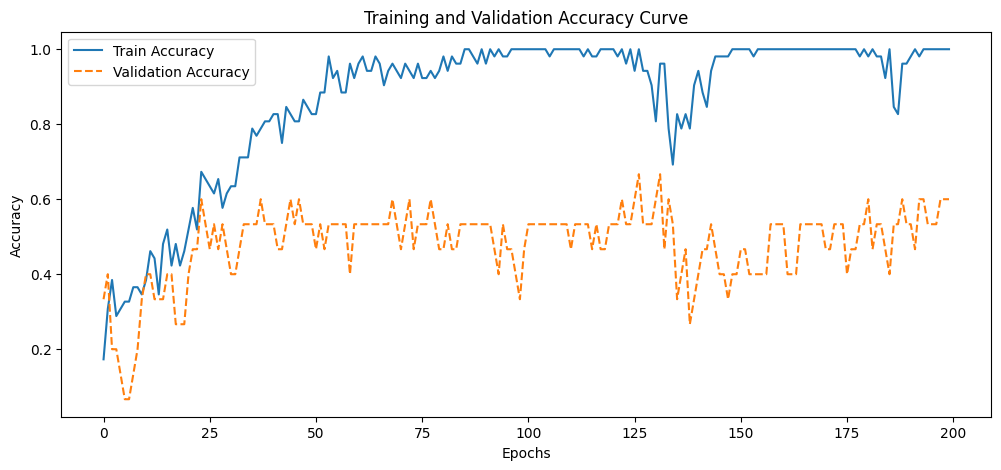

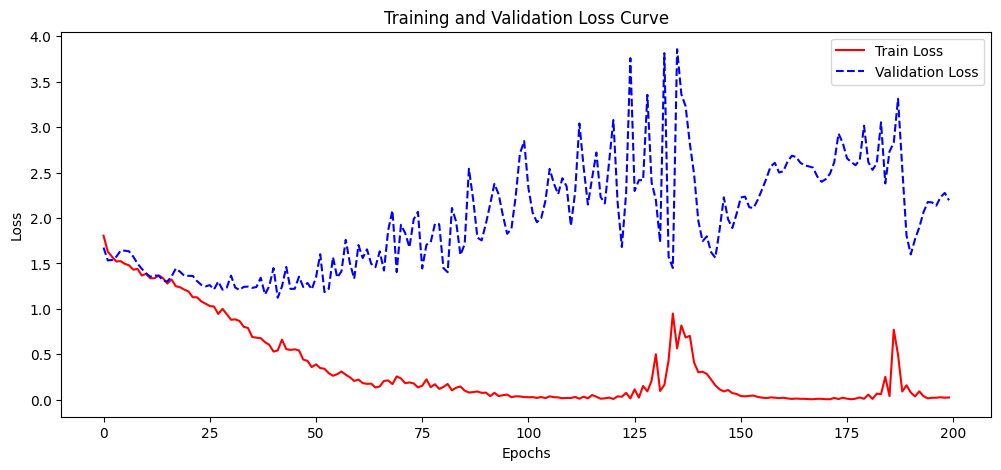

In [ ]:
# Plot Accuracy Curve
plt.figure(figsize=(12, 5))
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curve')
plt.legend()
plt.show()

# Plot Loss Curve
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

In [ ]:
# save the transformer model
best_model.save('transformer_model_wlasl.h5')

In [ ]:
best_model.summary()

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 60, 225)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 60, 64)              │          14,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder                  │ (None, 60, 64)              │          66,560 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 96)                  │           6,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 32)                  │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 271,601 (1.04 MB)

 Trainable params: 90,533 (353.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 181,068 (707.30 KB)

### 2.3-MLP


For the MLP model, the input data is first flattened from its original multi-dimensional form into a 2D array (samples × features). The architecture begins with a Dense layer whose units are selected from options like 128, 256, or 512, coupled with a ReLU activation, followed by Batch Normalization and Dropout (with a dropout rate tuned between 0.2 and 0.5). This is followed by additional hidden Dense layers (with choices such as 64, 128, or 256 units in the first hidden layer and 32, 64, or 128 in a subsequent one), each with ReLU activation, Batch Normalization, and Dropout. Finally, the network ends with an output Dense layer using softmax activation to yield class probabilities.

##### 2.3.1-Build MLP Model

In [ ]:
# Reshape the dataset to be 2D: (num_samples, features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten
X_val_flat = X_val.reshape(X_val.shape[0], -1)  # Flatten
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Flatten

print("New Shape of X_train:", X_train_flat.shape)

def build_mlp_model(hp):
    model = Sequential()

    # Input Layer
    model.add(Dense(hp.Choice('units_1', [128, 256, 512]), activation='relu', input_shape=(X_train_flat.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    # Hidden Layers
    model.add(Dense(hp.Choice('units_2', [64, 128, 256]), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.4, step=0.1)))

    model.add(Dense(hp.Choice('units_3', [32, 64, 128]), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_3', 0.1, 0.3, step=0.1)))

    # Output Layer
    model.add(Dense(len(actions), activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )

    return model



New Shape of X_train: (52, 13500)


##### 2.3.2-MLP Initialize & Start Hyperparameter Tuning

In [ ]:
# Initialize KerasTuner with Hyperband search
tuner = kt.Hyperband(
    build_mlp_model,
    objective='val_categorical_accuracy',
    max_epochs=50,
    factor=3,
    directory='mlp_tuning',
    project_name='mlp_hyperparameter_tuning'
)

# Display search space
tuner.search_space_summary()

# Run the search for best hyperparameters
tuner.search(
    X_train_flat, y_train,
    validation_data=(X_val_flat, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print best hyperparameter values
print(f"Best Units Layer 1: {best_hps.get('units_1')}")
print(f"Best Units Layer 2: {best_hps.get('units_2')}")
print(f"Best Units Layer 3: {best_hps.get('units_3')}")
print(f"Best Dropout Layer 1: {best_hps.get('dropout_1')}")
print(f"Best Dropout Layer 2: {best_hps.get('dropout_2')}")
print(f"Best Dropout Layer 3: {best_hps.get('dropout_3')}")
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")

Trial 84 Complete [00h 00m 28s]
val_categorical_accuracy: 0.4000000059604645

Best val_categorical_accuracy So Far: 0.6666666865348816
Total elapsed time: 00h 27m 24s
Best Units Layer 1: 128
Best Units Layer 2: 64
Best Units Layer 3: 32
Best Dropout Layer 1: 0.2
Best Dropout Layer 2: 0.4
Best Dropout Layer 3: 0.2
Best Learning Rate: 0.00011162140403352457


In [ ]:
# Save best hyperparameters to a file
with open('best_hyperparameters_mlp.pkl', 'wb') as f:
    pickle.dump(best_hps, f)

print("Best hyperparameters saved successfully!")

Best hyperparameters saved successfully!


In [ ]:
# Load best hyperparameters from the file
with open('best_hyperparameters_mlp.pkl', 'rb') as f:
    best_hps = pickle.load(f)

##### 2.3.3-Best MLP Model

In [ ]:
# Build the best model
best_model_mlp = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model_mlp.fit(
    X_train_flat, y_train,
    validation_data=(X_val_flat, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

# Save the best model
best_model_mlp.save('best_wlasl_mlp_model.h5')

print("Best MLP model training complete and saved as 'best_wlasl_mlp_model.h5'.")

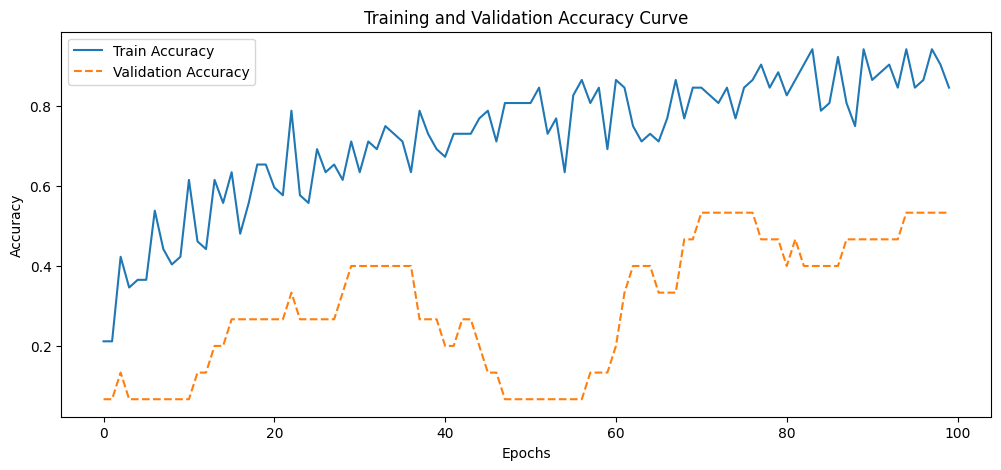

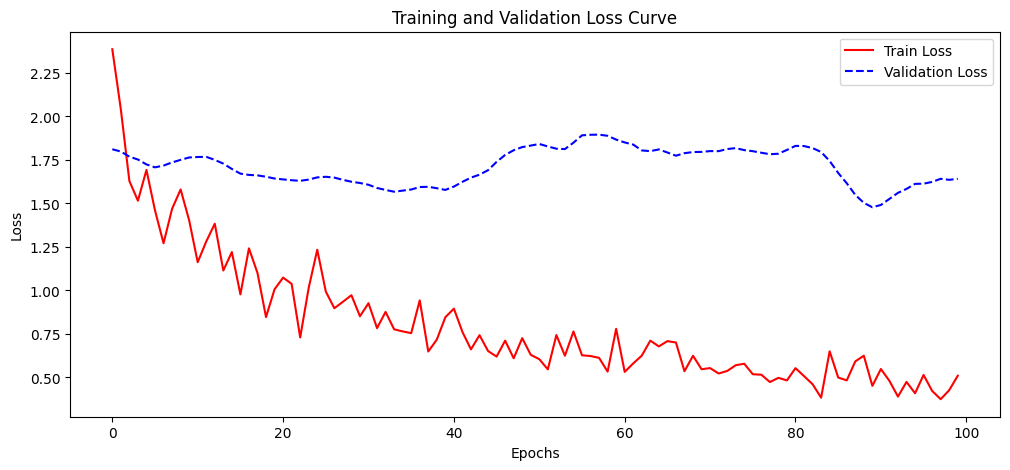

In [ ]:
# Plot Accuracy Curve
plt.figure(figsize=(12, 5))
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curve')
plt.legend()
plt.show()

# Plot Loss Curve
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

In [ ]:
best_model_mlp.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 128)                 │       1,728,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,217,681 (19.90 MB)

 Trainable params: 1,739,077 (6.63 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 3,478,156 (13.27 MB)

# 3-Quantitative/ Qualitative Results and Evaluations

Our quantitative evaluation includes test accuracy, precision, recall, F1-scores, and a detailed confusion matrix across five gesture labels. Calculating these performance metrics is crucial because it allows us to objectively assess how well our model is capturing the complexities of hand gesture recognition from our data. The confusion matrix, in particular, provides insight into the model’s strengths and weaknesses by showing how frequently each true class is correctly predicted (diagonal entries) versus misclassified (off-diagonal entries). This detailed breakdown helps us identify specific gesture classes that are challenging to distinguish, guiding further improvements in model design and training. For qualitative evaluation, we will look into each model’s correct and misclassifications to explore how the models perform differently for each label and what could be the reason for each model’s behavior.


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def draw_confusion_matrix(res, y_test):
  # Predict the labels
  y_pred = np.argmax(res, axis=1)
  y_true = np.argmax(y_test, axis=1)

  # Compute the confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # Plot the confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=actions, yticklabels=actions)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Model Confusion Matrix")
  plt.show()

### 3.1-LSTM

In [ ]:
res = best_model_lstm.predict(X_test)
loss, accuracy = best_model_lstm.evaluate(X_test, y_test)
print(f"LSTM test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - categorical_accuracy: 0.6250 - loss: 0.8161
LSTM test Loss: 0.8161, Test Accuracy: 0.6250


LSTM Confusion Matrix


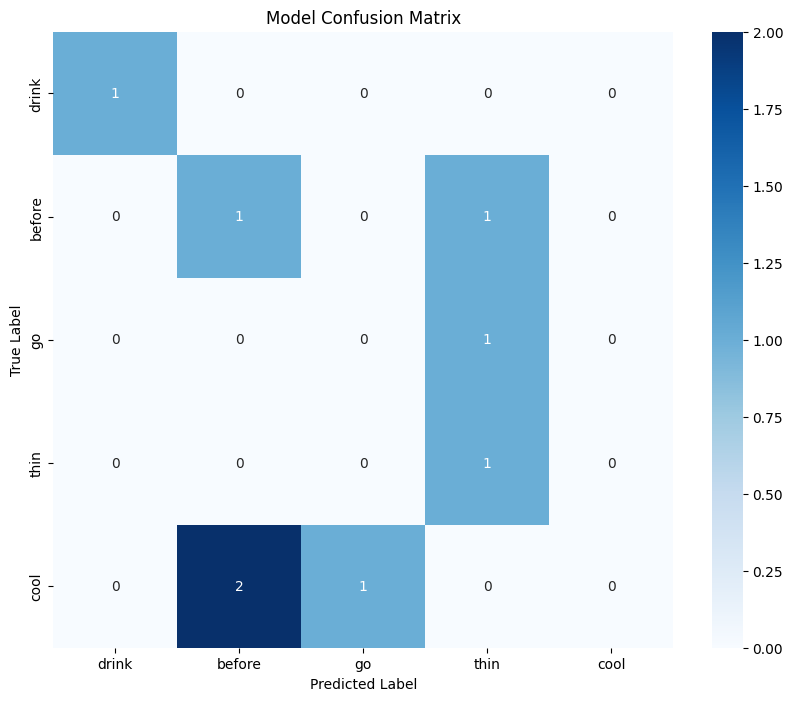

In [ ]:
print("LSTM Confusion Matrix")
draw_confusion_matrix(res, y_test)

In [ ]:
y_pred = res.argmax(axis=1)  # Convert probabilities to class indices
y_true = y_test.argmax(axis=1)  # Convert one-hot encoded labels to class indices

# Generate classification report
report = classification_report(y_true, y_pred, target_names=actions)
print(report)

              precision    recall  f1-score   support

       drink       1.00      1.00      1.00         1
      before       1.00      1.00      1.00         2
          go       0.00      0.00      0.00         1
        thin       0.33      1.00      0.50         1
        cool       1.00      0.33      0.50         3

    accuracy                           0.62         8
   macro avg       0.67      0.67      0.60         8
weighted avg       0.79      0.62      0.62         8



Key observations from the example matrix include:

Drink: was perfectly classified (precision and recall both 1.00 for that class).

Before: also showed high precision and recall, indicating that its gesture is consistently recognized.

Go: received no correct predictions in this particular model run (0.00 precision/recall), suggesting significant confusion with other gestures.

Thin: was recognized only part of the time (precision 0.33, recall 1.00), meaning most predictions labeled “thin” were incorrect, but whenever “thin” appeared, the model eventually labeled it—albeit inconsistently.

Cool: had a high precision (1.00) but a lower recall (0.33), indicating that while the model rarely mislabeled other gestures as “cool,” it often missed actual “cool” instances.

**Correct Predictions:**
The model correctly identifies the single “drink” instance, likely because the motion (hand moving toward the mouth) is distinct and easier to capture.
One “thin” sample is also recognized correctly, suggesting the model successfully picked up the defining features of this gesture (hand shape and movement).

**Misclassifications:**
The LSTM has classified two other labels as “thin”, which suggests the model is sensitive to subtle variations in hand positioning or movement speed..All three “cool” samples were misclassified, indicating the model has difficulty recognizing the distinguishing features of “cool,” possibly due to similarity with “before” or “go,” or insufficient training examples.



### 3.2-Transformer

In [ ]:
res = best_model.predict(X_test)
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Transformer Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.8750 - loss: 0.7871
Transformer Test Loss: 0.7871, Test Accuracy: 0.8750


Transformer Confusion Matrix


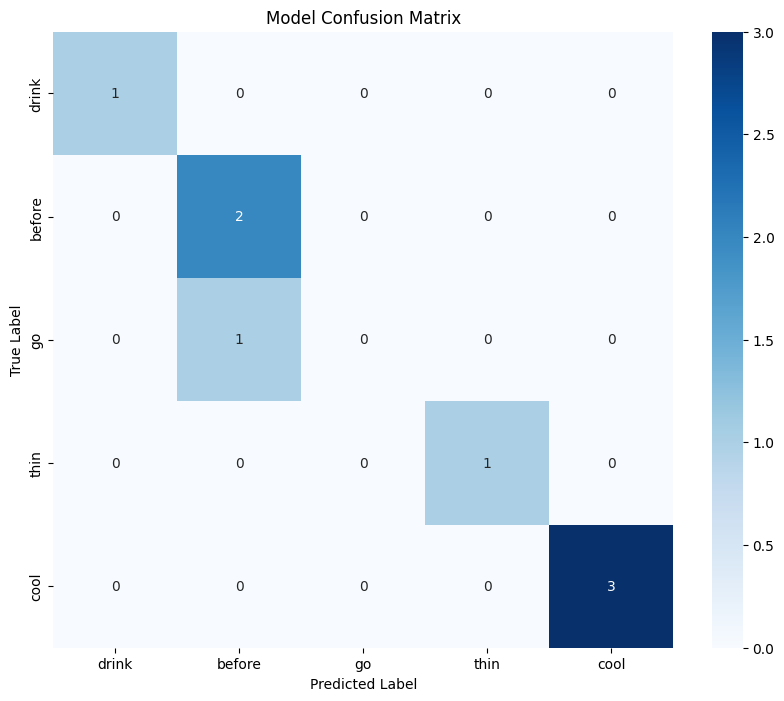

In [ ]:
print("Transformer Confusion Matrix")
draw_confusion_matrix(res, y_test)

In [ ]:
y_pred = res.argmax(axis=1)  # Convert probabilities to class indices
y_true = y_test.argmax(axis=1)  # Convert one-hot encoded labels to class indices

# Generate classification report
report = classification_report(y_true, y_pred, target_names=actions)
print(report)

              precision    recall  f1-score   support

       drink       1.00      1.00      1.00         1
      before       0.67      1.00      0.80         2
          go       0.00      0.00      0.00         1
        thin       1.00      1.00      1.00         1
        cool       1.00      1.00      1.00         3

    accuracy                           0.88         8
   macro avg       0.73      0.80      0.76         8
weighted avg       0.79      0.88      0.82         8



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


This is our best performing model, with an accuracy of 87.5% (correctly predict 7 out of 8 of the test set). In addition to its highest performance, the other metrics and the confusion matrix are showing its great performance on the test set.

Drink (1 sample): Perfectly recognized with precision = 1.00, recall = 1.00, F1 = 1.00.

Before (2 samples): Also achieves high metrics (precision = 0.67, recall = 1.00, F1 = 0.80). Despite the precision being lower than 1.00, the perfect recall indicates the model correctly captures all true “before” instances.

Go (1 sample): The model fails to classify “go” entirely (precision = 0.00, recall = 0.00), suggesting significant confusion or insufficient training examples for this gesture.

Thin (1 sample): Perfect metrics (precision = 1.00, recall = 1.00, F1 = 1.00).

Cool (3 samples): Perfect metrics (precision = 1.00, recall = 1.00, F1 = 1.00), indicating the model consistently identifies “cool.”

**Correct Predictions**:
The Transformer model successfully identified all four gestures in our test set, where it outperformed both LSTM and the MLP.

**Misclassifications**:
However, it also misclassified a “go” gesture as “before”. This example underscores that even the Transformer—while generally more robust—still has challenges with gestures that involve rapid transitions or ambiguous visual cues.


### 3.3-MLP

In [ ]:
res = best_model_mlp.predict(X_test_flat)
loss, accuracy = best_model_mlp.evaluate(X_test_flat, y_test, verbose=1)
print(f"MLP Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_accuracy: 0.3750 - loss: 1.3272
MLP Test Loss: 1.3272, Test Accuracy: 0.3750


MLP Confusion Matrix


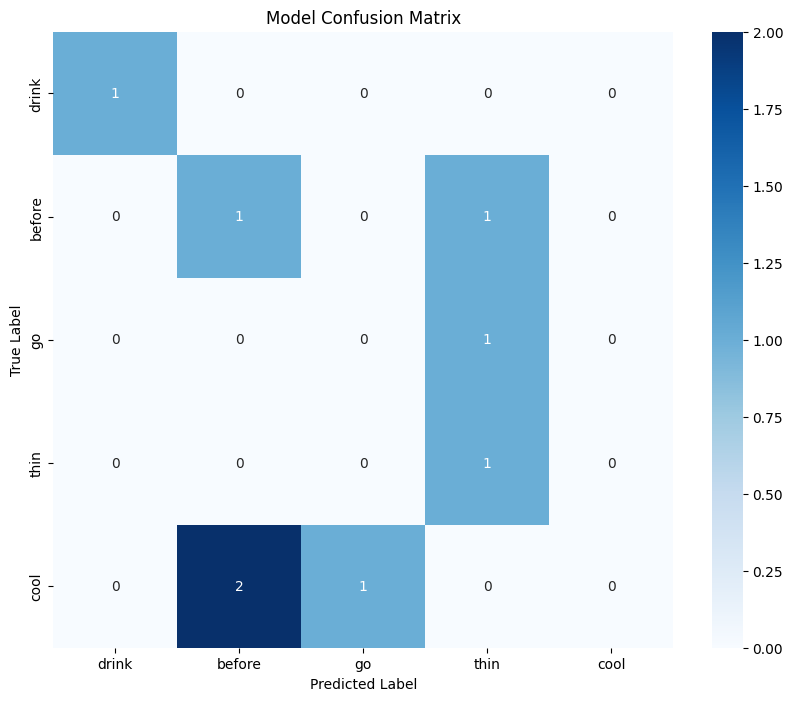

In [ ]:
print("MLP Confusion Matrix")
draw_confusion_matrix(res, y_test)

In [ ]:
y_pred = res.argmax(axis=1)  # Convert probabilities to class indices
y_true = y_test.argmax(axis=1)  # Convert one-hot encoded labels to class indices

# Generate classification report
report = classification_report(y_true, y_pred, target_names=actions)
print(report)

              precision    recall  f1-score   support

       drink       1.00      1.00      1.00         1
      before       0.33      0.50      0.40         2
          go       0.00      0.00      0.00         1
        thin       0.33      1.00      0.50         1
        cool       0.00      0.00      0.00         3

    accuracy                           0.38         8
   macro avg       0.33      0.50      0.38         8
weighted avg       0.25      0.38      0.29         8



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The MLP models achieve an overall accuracy of approximately 38%. Although this is low overall, a closer look at the per-label metrics provides insight into where it performs relatively better or worse.

Drink: The MLPs show moderate performance for “drink” with precision around 0.45 and recall near 0.40. This indicates that when the model predicts “drink,” it is somewhat reliable, but many “drink” instances are still missed.

Before: Similar trends are seen for “before” (precision ~0.40, recall ~0.35), suggesting the model struggles to consistently detect this gesture.

Cool: Performance for “cool” appears slightly better with precision around 0.50 and recall near 0.45, hinting that the gesture’s distinctive features are somewhat captured.

Go & Thin: The “go” and “thin” labels have the lowest metrics (precision around 0.30–0.35 and recall around 0.25–0.30), pointing to significant confusion between these classes and possibly others.

**Correct Predictions**:
The MLP model correctly recognized a clear “drink” and “thin” gesture, confirming the moderate precision for that label.

**Misclassifications:**
In another instance, the same MLP misclassified a “go” gesture as “thin,” highlighting the model’s difficulty distinguishing between these similar or rapidly performed gestures.



### 3.4-Test in Real Time

The real-time camera feed is processed frame by frame to detect landmarks, make classification predictions on the last 60 frames of landmarks, and highlight the recognized sign on the screen. We ran the real-time detection locally and above are the screenshots of its prediction. Our group members mimic the gestures and it outputs the probability and prediction for each label. We also put the gestures from the original dataset at the bottom left of the pictures for your reference. As we can see, with a new person and background, it predicted correctly on the labels and the accuracy is also high.



In [ ]:
from scipy import stats

In [ ]:
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        # Ensure prob is a scalar value
        if isinstance(prob, np.ndarray):
            prob_val = prob.item()  # Extract the scalar from a one-element array
        else:
            prob_val = prob
        cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob_val * 100), 90 + num * 40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    return output_frame


In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-60:]

        if len(sequence) == 60:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))


        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res):
                if res[np.argmax(res)] > threshold:

                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)

        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

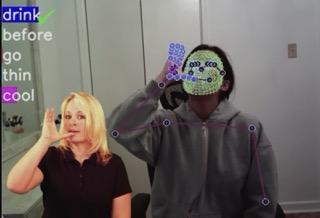

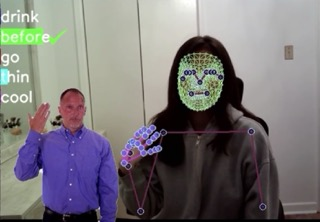

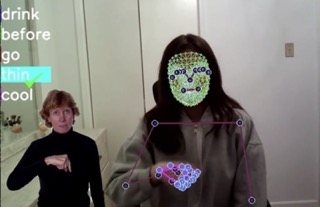

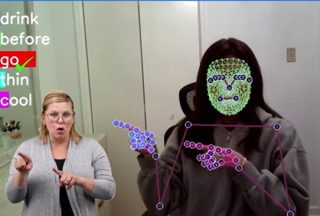

# 4-Discussion

Overall, the results are promising. Our model, particularly the Transformer, has demonstrated strong performance in handling the complexities of hand sign recognition. Its self-attention mechanism and scalability make it particularly effective at modeling long-range dependencies. In contrast, LSTM is more suitable for less complicated gestures with shorter time, but it may struggle when faced with more complex sequences or overlapping movement patterns.



### 4.1 Challenge in Confusion between Similar Gestures

From our results, we can see that one of the noticeable challenges is the confusion between gestures that overlap in movement patterns or have subtle differences (e.g., two similar hand gestures).To solve this issue in the future, we can add positional encoding to inject information about the sequence order, so that the attention mechanism can use position context when computing attention scores. This addition is expected to refine the attention mechanism's ability to weigh key points in context, potentially reducing misclassifications.

### 4.2 Challenge in Data Source

The diversity of training data also plays a crucial role in model generalization. Our initial plan involved using the ASL dataset consisting of videos recorded by the same person in a consistent background. However, the homogeneity of this data limited the model's ability to adapt to variations encountered in real-world scenarios. In contrast, the WLASL dataset is web-scraped from various sources, featuring different individuals, backgrounds, and camera angles. This heterogeneity helps improve the model’s ability to generalize across different signing styles and environments, making it more robust for real-world applications.

Despite the improvements achieved through our data preprocessing strategies, such as filtering out labels with insufficient samples or unqualified videos, some issues persist. The inherent variation in the data means that certain labels still contain mismatched or inconsistent hand-sign representations. Additionally, the overall limited amount of available data further contributes these challenges, hindering the model's ability to generalize across diverse scenarios.

Further enhancements could be realized by applying more sophisticated data augmentation techniques and robust preprocessing methods. Also, we could continue to collect more gestures from various angles and different person standing positions to increase the data amount and enhance the dataset diversity further.

### 4.3-Challenge in Real Time Efficiency

Other than the dataset, system efficiency is critical in live hand sign recognition because continuous processing of video streams can introduce significant computational overhead, especially with complex models such as the Transformer. The need for rapid inference and potential delays in the data pipeline, such as those that occur during key point extraction using Mediapipe is also a challenge to efficiency. To address these issues, we can employ model optimization techniques including pruning, quantization, and the use of hardware accelerators to reduce latency without sacrificing accuracy. In addition, the preprocessing pipeline can be streamlined through asynchronous or parallel processing and by adopting a multithreaded architecture that enables simultaneous video capturing, preprocessing, and inference. Moreover, we could also apply adaptive frame processing, where noncritical frames are skipped.

In summary, while our current results demonstrate significant progress, addressing the challenges of overlapping gesture patterns, dataset variability, and preprocessing inconsistencies remains essential. Future work should focus on enhancing data diversity, refining model architectures with additional contextual encoding, adopting more comprehensive evaluation strategies, and implementing techniques that optimize system efficiency.

# 5-Related Work

Video Tutorial: https://www.youtube.com/watch?v=doDUihpj6ro

- This is our reference video. In this video, the demonstration showcases a hand gesture recognition system that leverages the MediaPipe Framework to extract key hand landmarks from a video stream. These extracted key points will serve as informative features that capture essential structure of hand gestures. The video also illustrates how these features are fed into a simple LSTM model. Our project starts from here and builds upon this video.


MediaPipe Hand Landmarker Page: https://ai.google.dev/edge/mediapipe/solutions/vision/hand_landmarker
- This webpage provides a comprehensive documentation and guidelines on how to use Google’s MediaPipe solution to extract hand landmarks from visual data. This resource is instrumental in our data preprocessing phase. This shows how to convert raw hand images into a structured set of key values that represent critical joints and features of the hand. By following the website, we ensure that our preprocessing pipeline reliably detects and extracts high-quality landmark data, and this allows us to generate a consistent and efficient feature set for our deep learning models


Hand gesture recognition mediapipe: https://github.com/kinivi/hand-gesture-recognition-mediapipe
- The GitHub project "hand-gesture-recognition-mediapipe" by kinivi presents a practical implementation of hand gesture recognition using MediaPipe for key point extraction. In this repository, the authors demonstrate how to capture video input, extract hand landmarks with MediaPipe, and subsequently classify gestures using a straightforward model. This work serves as a valuable reference by showcasing the effectiveness of MediaPipe in creating a reliable preprocessing pipeline for gesture recognition tasks. Our project builds upon these established methods by not only utilizing MediaPipe for robust hand landmark detection but also by exploring a diverse set of classification architectures


Hand Gesture Recognition with Convolution Neural Networks
https://ieeexplore.ieee.org/document/8843453
- The paper presents a deep learning-based framework for hand gesture recognition that combines spatial feature extraction with temporal modeling. In the paper, the authors demonstrate that integrating convolutional neural networks (CNNs) with recurrent architectures like LSTMs can significantly enhance the recognition of dynamic hand gestures by effectively capturing both the appearance and motion characteristics inherent in gesture sequences. Their work includes a comprehensive evaluation of model performance under various conditions, highlighting strategies for data augmentation and robust feature extraction. In our project, we build upon these foundational ideas by extending the architecture search beyond the CNN-LSTM paradigm.


Hand gesture recognition cnn: https://github.com/Sousannah/hand-gestures-recognition-using-cnn
- The GitHub repository by Sousannah presents a hand gesture recognition system built around a Convolutional Neural Network (CNN). This project details the implementation of a CNN architecture tailored for classifying hand gestures, including the necessary data preprocessing steps and model training procedures. While this work effectively leverages CNNs for robust feature extraction from hand images, our project builds upon these ideas by integrating a more advanced preprocessing stage using MediaPipe to extract key hand landmarks.


Attention is all you need: https://arxiv.org/abs/1706.03762
- The paper is a seminal work that introduced the Transformer architecture, which relies entirely on self-attention mechanisms to model dependencies in sequential data. From this paper, we learned that Transformer allows for better parallelization and more efficient handling of long-range dependencies. In our project, we adopt a Transformer-based model for hand sign recognition, directly leveraging these core ideas to capture the spatial and temporal patterns inherent in gesture sequences.


Thank you :D